##1. Import **Libraries**

In [2]:
import numpy as np
import pandas as pd
import spacy
import pickle
import itertools
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##2. Data Downloading

In [4]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [5]:
# %pip install datasets

In [6]:
# from datasets import load_dataset
# import pandas as pd
# import json
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# import string 
# stop = stopwords.words('english')


# def get_dataset(x):
#     data = load_dataset("/content/drive/MyDrive/ColabNotebooks/tools/yahoo_answers_topics.py")
#     df=pd.DataFrame(data[x])
#     df['text']=df['question_title']+df['question_content']+df['best_answer']
#     return df


In [7]:

# dftrain=get_dataset('train')
# # dftest=get_dataset('test')

In [8]:
# def process_series(series, stop):
#     series = series.str.lower().str.replace('[^\w\s]', ' ').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#     return series

In [9]:
# dftrain['alltext']=dftrain['question_title']+dftrain['question_content']+dftrain['best_answer']
# # dftest['alltext']=dftest['question_title']+dftest['question_content']+dftest['best_answer']

In [10]:
# dftrain['cleanedtext']=process_series(dftrain['alltext'],stop)
# # dftest['cleanedtext']=process_series(dftest['alltext'],stop)

In [ ]:
# dftrain.to_csv('/content/drive/MyDrive/ColabNotebooks/data/train.csv')

In [ ]:
# dftest.to_csv('/content/drive/MyDrive/ColabNotebooks/data/test.csv')

##3. Data Visualization

##4. Preprocessing Data

In [11]:
# # !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [12]:
df=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/data/yahoo_train.csv')

In [13]:
df=df[df.topic.isin([0,1,2])]

In [14]:
df=df[df['text_clean'].convert_dtypes(convert_string=True).notnull()]

In [15]:
cleaned_data=df['text_clean'].to_list()

In [16]:
len(cleaned_data)

420000

In [17]:
b_file = open("/content/drive/MyDrive/ColabNotebooks/data/cleaned_data.pkl", "wb")
pickle.dump(cleaned_data, b_file)
b_file.close()

In [18]:
def encoding_data(cleaned_data):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(cleaned_data)

    # word_index is a dictionary contains indeces for the words like {'for': 8, 'is': 9, 'me': 10, ...}
    word_index = tokenizer.word_index

    # train_sequences is vectors where each vector represents a sentence
    data_sequences = tokenizer.texts_to_sequences(cleaned_data)
    data_sequences = pad_sequences(data_sequences, maxlen=10, padding="post")



    with open("/content/drive/MyDrive/ColabNotebooks/data/tokenizer.pkl","wb") as file:
        pickle.dump(tokenizer,file)

    return data_sequences, word_index
#------------------------------------------------------------------#
data_sequences, word_index = encoding_data(cleaned_data)

with open("/content/drive/MyDrive/ColabNotebooks/data/data_sequences.pkl","wb") as file:
    pickle.dump(data_sequences,file)

with open("/content/drive/MyDrive/ColabNotebooks/data/word_index.pkl","wb") as file:
    pickle.dump(word_index,file)

##5. Importing GloVe dataset

In [19]:
!pip install wget
import wget
url ='https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

def GloVe(data = 'glove.6B.100d.txt'):

  embeddings_index={}
  with open(data, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
  return embeddings_index
#--------------------------------------------------------------------------------------------#
def embeddingWeights(word_index, max_num_words=500000):
  embeddings_index = GloVe()
  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = all_embs.mean(), all_embs.std()

  num_words = min(max_num_words, len(word_index))+1

  embedding_dim=len(embeddings_index['the'])

  embedding_weights = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))

  for word, i in word_index.items():
      if i >= max_num_words:
          break
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_weights[i] = embedding_vector
  
  return embedding_weights, num_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=9cfba620b4519436341a79d196175bebd69ba23b26148ca8d154883fa1ea0b25
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [20]:
embedding_weights, num_words = embeddingWeights(word_index)

a_file = open("/content/drive/MyDrive/ColabNotebooks/data/embedding_wights.pkl", "wb")
pickle.dump(embedding_weights, a_file)
a_file.close()

a_file = open("/content/drive/MyDrive/ColabNotebooks/data/num_words.pkl", "wb")
pickle.dump(num_words, a_file)
a_file.close()

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
# # # Importing all the variables from Google Drive
# with open('/content/drive/MyDrive/ColabNotebooks/data/cleaned_data.pkl','rb') as file:
#   cleaned_data = pickle.load(file)

# # with open('/content/drive/MyDrive/yahoo-answers-dataset/data_label.pkl','rb') as file:
# #   data_label = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/data_sequences.pkl','rb') as file:
#   data_sequences = pickle.load(file)

# # with open('/content/drive/MyDrive/yahoo-answers-dataset/dic.pkl','rb') as file:
# #   dic = pickle.load(file)

# # with open('/content/drive/MyDrive/yahoo-answers-dataset/label_encoder.pkl','rb') as file:
# #   label_encoder = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/num_words.pkl','rb') as file:
#   num_words = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/tokenizer.pkl','rb') as file:
#   tokenizer = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/word_index.pkl','rb') as file:
#   word_index = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/embedding_wights.pkl','rb') as file:
#   embedding_wights = pickle.load(file)

In [23]:
data_label=df['topic'].to_numpy()

##6. Splitting the Data

In [24]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(data_sequences, data_label,test_size = 0.2, stratify=data_label)
test_data, val_data, test_labels, val_labels = train_test_split(val_test_data, val_test_labels, test_size = 0.5, stratify=val_test_labels)

##7. Model Preparation and Training

In [26]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, trainable=False, input_length=10, weights=[embedding_weights]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2), 'concat'))
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss ='sparse_categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

In [27]:
 print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 100)           45499500  
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 512)          731136    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 10, 512)           0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           328192    
                                                                 
 dropout_5 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                      

In [28]:
# model = load_model('/content/drive/MyDrive/ColabNotebooks/data/modeltrainable.h5')

In [29]:
stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose = 1, factor = 0.1, min_delta=0.001, min_lr = 0.00001)

history = model.fit(train_data, train_labels, epochs = 20,
          batch_size = 1024, shuffle=True,
          validation_data=[val_data, val_labels],
          callbacks=[reduce_lr, stopping])

model.save('/content/drive/MyDrive/ColabNotebooks/data/modeltrainable.h5')

Epoch 1/20
329/329 [==============================] - 960s 3s/step - loss: 0.6634 - accuracy: 0.7234 - val_loss: 0.5847 - val_accuracy: 0.7602 - lr: 0.0010
Epoch 2/20
329/329 [==============================] - 911s 3s/step - loss: 0.5800 - accuracy: 0.7654 - val_loss: 0.5587 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 3/20
329/329 [==============================] - 881s 3s/step - loss: 0.5581 - accuracy: 0.7755 - val_loss: 0.5385 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 4/20
329/329 [==============================] - 892s 3s/step - loss: 0.5442 - accuracy: 0.7820 - val_loss: 0.5296 - val_accuracy: 0.7855 - lr: 0.0010
Epoch 5/20
329/329 [==============================] - ETA: 0s - loss: 0.5347 - accuracy: 0.7865
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
329/329 [==============================] - 895s 3s/step - loss: 0.5347 - accuracy: 0.7865 - val_loss: 0.5279 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 6/20
329/329 [==============================] - 892s

In [30]:
model.evaluate(test_data, test_labels)

1313/1313 [==============================] - 78s 59ms/step - loss: 0.5152 - accuracy: 0.7930


[0.5151677131652832, 0.7930238246917725]

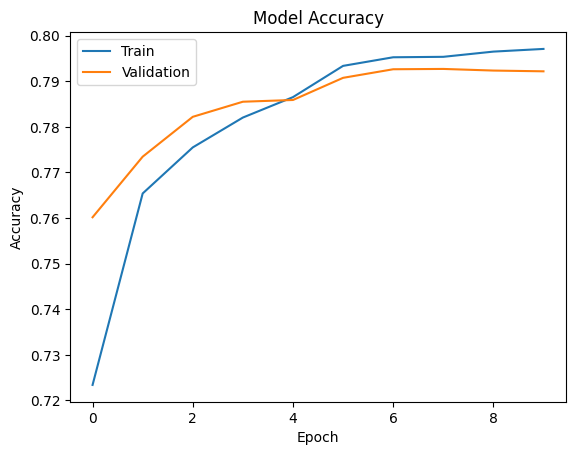

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

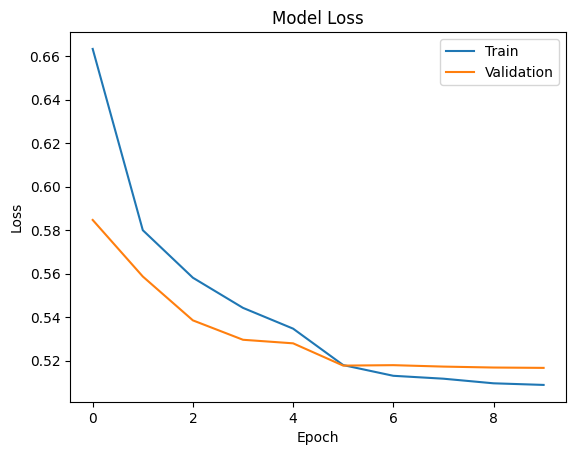

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [33]:
#getting some more metrics for the model

# predict crisp classes for test set
yhat_classes = model.predict(test_data, verbose=0)
 

In [34]:
yhat_classes=np.argmax(yhat_classes, axis=-1)

In [35]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, yhat_classes,average='macro')
print('Precision: ',precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, yhat_classes,average='macro')
print('Recall:' , recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, yhat_classes,average='macro')
print('F1 score:' ,f1)
 
# kappa
kappa = cohen_kappa_score(test_labels, yhat_classes)
print('Cohens kappa: %f' % kappa)

# confusion matrix
matrix = confusion_matrix(test_labels, yhat_classes)
print(matrix)

Accuracy: 0.793024
Precision:  0.7951381797244309
Recall: 0.7930238095238096
F1 score: 0.7932761793230251
Cohens kappa: 0.689536
[[11463  1173  1364]
 [ 1639 10898  1463]
 [ 2095   959 10946]]


<Axes: xlabel='Predicted Values', ylabel='True Values'>

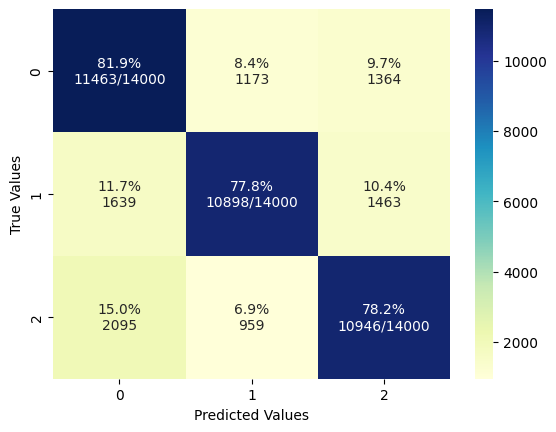

In [37]:
import seaborn as sns 
cm_sum = np.sum(matrix, axis=1, keepdims=True)
cm_perc = matrix / cm_sum.astype(float) * 100
annot = np.empty_like(matrix).astype(str)
nrows, ncols = matrix.shape
for i in range(nrows):
    for j in range(ncols):
        c = matrix[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = '0.0%'
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(matrix, index=np.unique(test_labels), columns=np.unique(test_labels))
cm.index.name = 'True Values'
cm.columns.name = 'Predicted Values'
fig, ax = plt.subplots()

sns.heatmap(cm, cmap= "YlGnBu", annot=annot,fmt='',ax=ax)